# Paintball
Go through the paintball example in chapter 9

In [1]:
import thinkbayes2
import thinkplot
import numpy as np
import math
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/francesco/PersonalProjects/ThinkBayes2/')
from scripts import paintball

The problem is clear: there is a shooter in an unknown position in a room and we only observe his bullets hitting the wall. We want to infer his position from the observations.

The position is in 2D and we are supposing that the he is shooting towards a single wall. The (unknown) position of the shooter is expressed by $(\alpha, \beta)$, the position of the bullet is $x$ and the shooting angle is $\theta$:

<img src="paintball.png" style="width: 200px;"/>

The general approach to this kind of problems is always the same: let's treat the quantities we want to find as parameters when trying to find the probability distribution of the data, in this case P($x$|$\alpha$,$\beta$). Than, using Bayes' theorem, we can compute the posterior of the parameters given the data.

As stated above, we observe the position of the bullet $\alpha + x$ and we want to infer the position of the shooter $(\alpha, \beta)$. As a first step we need to find a connection between the two:
$$x - \alpha = \beta \tan \theta$$

From the book:
> As a simple model, imagine that the opponent is like a rotating turret, equally likely to shoot in any direction.

This means assuming that $\theta$ has a uniform distribution. In order to check what this assumption means in terms of $x$, let's assume we know $\alpha$ and $\beta$, which then fixes the lower and upper bounds for $\theta$, assuming that the shooter only shoots towards one wall and we know the lenght of the wall ($L$).

In [2]:
L = 30
alpha = 10
beta = 15

thetaMin = - ((math.pi/2) - math.atan2(beta, alpha))
thetaMax = math.atan2((L-alpha), beta)

theta = np.random.uniform(thetaMin, thetaMax, 20000)
#theta = np.random.triangular(thetaMin, thetaMin,thetaMax, 20000)
x = beta * np.tan(theta) + alpha

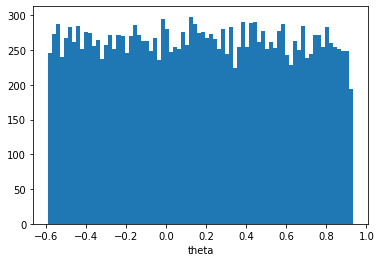

In [3]:
step = .02
bins = np.arange(thetaMin, thetaMax+step, step)

plt.figure()
plt.hist(theta, bins=bins);

plt.xlabel('theta');

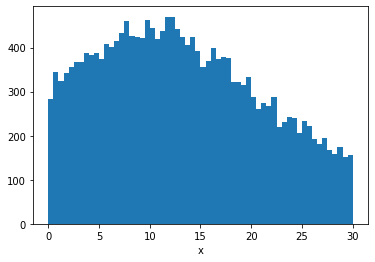

In [4]:
step = .5
bins = np.arange(x.min(), x.max()+step, step)

plt.figure()
plt.hist(x, bins=bins);

plt.xlabel('x');

The above makes sense, of course and it is the reason behind the next sentence in the book:
> In that case, he is most likely to hit the wall at location `alpha`, and less likely to hit the wall far away from `alpha`.

Here one should investigate better the transformation of the probability distribution in order to get the exact P($x$) given P($\theta$) and the relationship between the two variables.

The main idea to solve the problem is: once we observe $x$, we can compute $\theta$ simply reversing the above formula:
$$\theta = \tan^{-1}(\frac{x - \alpha}{\beta})$$

Then Allen claims that the probability of $x$ is proportional to the inverse of the derivative of $x$ wrt/ $\theta$, $\frac{\textrm{d}x}{\rm{d}\theta}$:
$$\frac{\textrm{d} x}{\rm{d}\theta} = \frac{\beta}{\cos^{2}\theta} = s(\theta)$$

So in principle, having $\alpha$ and $\beta$ it is possible to compute P($x$):
$$\textrm{P}(x) \propto \frac{1}{s(\theta(\alpha,\beta))}$$
This is computed in `MakeLocationPmf(...)`.

In [5]:
locations = np.linspace(0, L, 1000)
pmf = paintball.MakeLocationPmf(alpha, beta, locations)

No handles with labels found to put in legend.


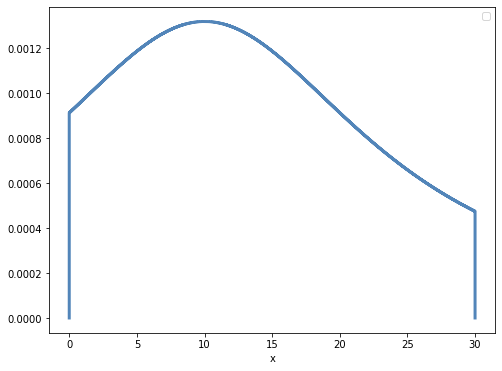

In [6]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf(pmf)
thinkplot.config(xlabel='x',
                ylable='PMF')

The above is consistent with the empiric distribution found earlier.

The above formula of P($x$) is indeed P($x$|$\alpha$, $\beta$) which is all we need to compute the likelihood, and indeed it's used in the `Paintball` class:
```
def Likelihood(self, data, hypo):
    """Computes the likelihood of the data under the hypothesis.
    hypo: pair of alpha, beta
    data: location of a hit
    Returns: float likelihood
    """
    alpha, beta = hypo
    x = data
    pmf = MakeLocationPmf(alpha, beta, self.locations)
    like = pmf.Prob(x)
    return like
```
In particular `hypo` contains the hypotetical pair ($\alpha$, $\beta$), this pair is used to compute the P($x$) distribution and then the particular value of the observed $x$ is taken.

Here the important thing is that the hypotheses are composed of 2 values, $\alpha$ and $\beta$ and indeed what we want to find is the position of the shooter in a 2D space, i.e. P($\alpha$, $\beta$), and therefore we obtain a joint distribution.

Go through the full example:

In [7]:
alphas = range(31)
betas = range(1, 51)
locations = range(31)

suite = paintball.Paintball(alphas, betas, locations)

Plot priors on $\alpha$ and $\beta$

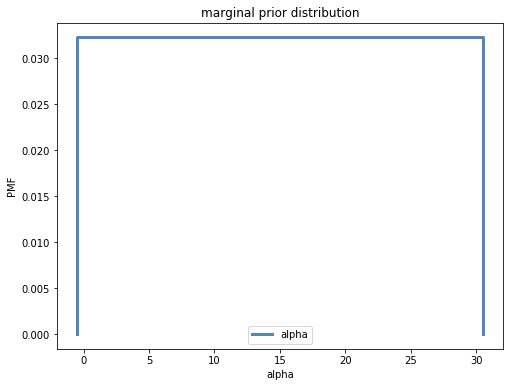

In [8]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf( suite.Marginal(0, label='alpha') )
thinkplot.Config(xlabel='alpha',
                ylabel='PMF',
                title='marginal prior distribution')

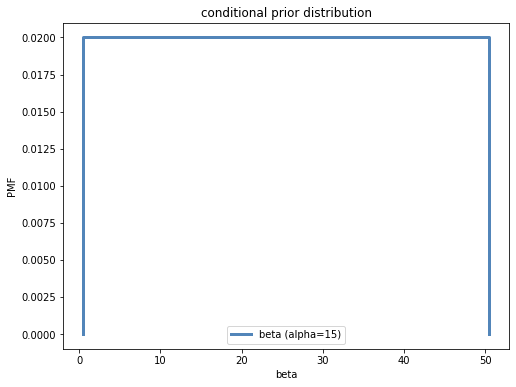

In [9]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf( suite.Conditional(1, 0, 15, label='beta (alpha=15)') )
thinkplot.Config(xlabel='beta',
                ylabel='PMF',
                title='conditional prior distribution')

Now update with observed values of $x$

In [10]:
suite.UpdateSet([15, 16, 18, 21])

1.9032915958109017e-06

Check the posteriors

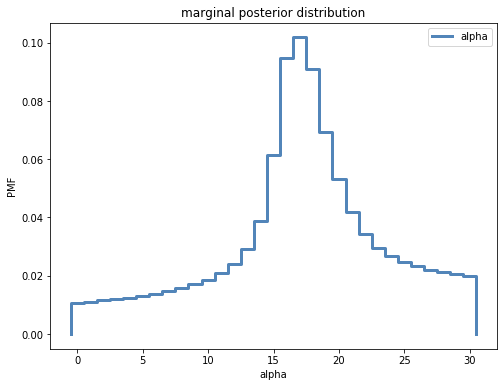

In [11]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf( suite.Marginal(0, label='alpha') )
thinkplot.Config(xlabel='alpha',
                ylabel='PMF',
                title='marginal posterior distribution')

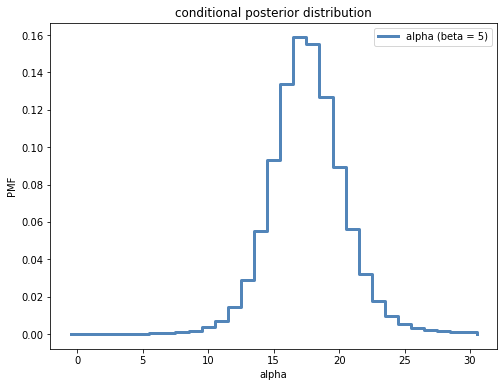

In [12]:
beta = 5
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf( suite.Conditional(0, 1, beta, label=f'alpha (beta = {beta})') )
thinkplot.Config(xlabel='alpha',
                ylabel='PMF',
                title='conditional posterior distribution')

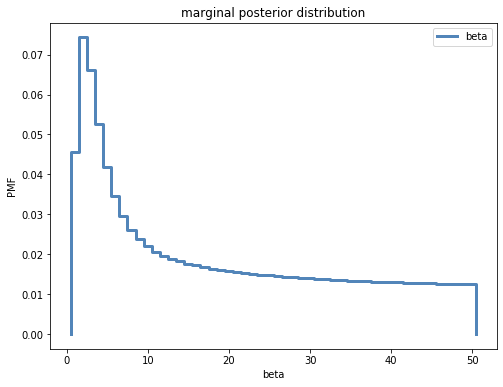

In [13]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf( suite.Marginal(1, label='beta') )
thinkplot.Config(xlabel='beta',
                ylabel='PMF',
                title='marginal posterior distribution')

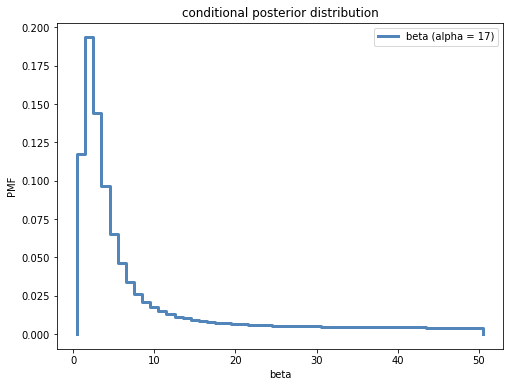

In [14]:
alpha = 17
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf( suite.Conditional(1, 0, alpha, label=f'beta (alpha = {alpha})') )
thinkplot.Config(xlabel='beta',
                ylabel='PMF',
                title='conditional posterior distribution')

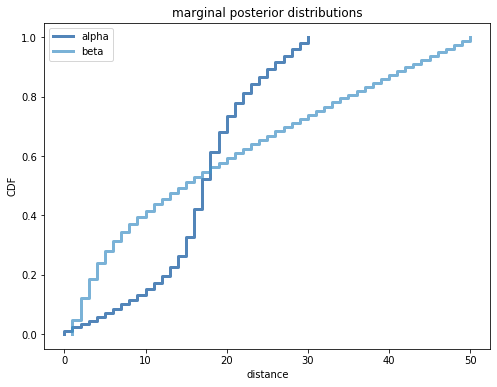

In [15]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pdfs( [suite.Marginal(0, label='alpha').MakeCdf(), suite.Marginal(1, label='beta').MakeCdf()] )
thinkplot.Config(xlabel='distance',
                ylabel='CDF',
                title='marginal posterior distributions')

In [16]:
suite.MaxLikeInterval(10)

[(17, 2), (16, 2), (16, 1), (17, 3), (18, 2), (18, 3), (17, 1)]

In [17]:
percentages = [25, 50, 75]

## create an empty dictionary (pair) --> prob
d = dict((pair, 0) for pair in suite.Values())

for p in percentages:
    
    ## get the pairs in the given percentage
    interval = suite.MaxLikeInterval(p)
    
    for pair in interval:
        d[pair] += 1
    

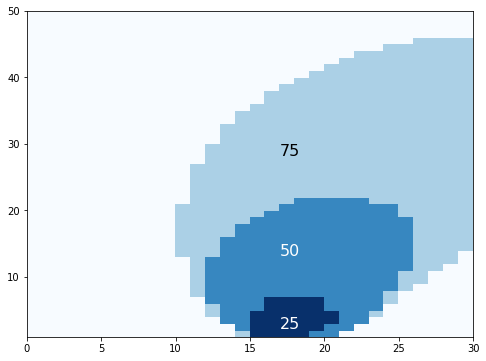

In [18]:
thinkplot.Clf()
thinkplot.Contour(d, pcolor=True, contour=False)

thinkplot.Text(17, 4, '25', color='white')
thinkplot.Text(17, 15, '50', color='white')
thinkplot.Text(17, 30, '75')

/Users/francesco/anaconda3/envs/ThinkBayes2/lib/python3.7/site-packages/thinkplot/thinkplot.py:584: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = plt.contour(X, Y, Z, **options)


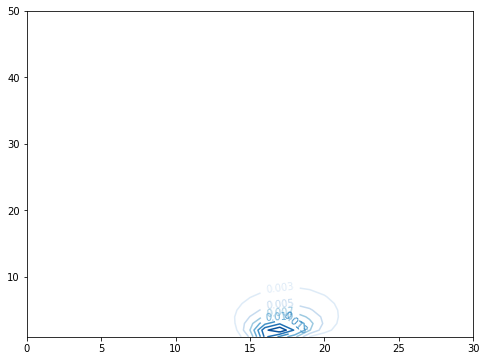

In [19]:
thinkplot.Clf()
thinkplot.Contour(suite.GetDict(), contour=True, pcolor=False)

**Exercise 9.1**: In our simple model, the opponent is equally likely to shoot in any
direction. As an exercise, let’s consider improvements to this model.

The analysis in this chapter suggests that a shooter is most likely to hit the closest wall. But in reality, if the opponent is close to a wall, he is unlikely to shoot at the wall because he is unlikely to see a target between himself and the wall.

Design an improved model that takes this behavior into account. Try to find a model that is more realistic, but not too complicated.

**Solution**: as stated above, the simplification consists in the fact that the shooter is always equally likely to shoot in every direction, while in general the direction of the shoot depends on his position.

In order to implement a more realistic model we can make the probability distribution of $\theta$ dependent on $\alpha$ and $\beta$: the main idea is that the shooter is more likely to shoot in the direction where there is more space, kind of assuming that the target will be there.

<img src="paintball2.png" style="width: 200px;"/>

When the shooter is in position 1, $\alpha \sim \beta$ and the shooter is indeed equally likely to shoot in any direction between $\theta_{\rm min}$ and $\theta_{\rm max}$. When the shooter is in position 2 ($\alpha < \beta$) the shooter is more likely to shoot toward $\theta_{\rm max}$ rather than $\theta_{\rm min}$. On the other hand, when the shooter is in position 3 ($\alpha > \beta$) he is more likely to shoot towards $\theta_{\rm min}$ rather than $\theta_{\rm max}$.

When the shooter is in the upper half of the room there is enough space between him and the wall that he is equally likely to shoot in any direction.

Here we are introducing a new form of P($\theta$|$\alpha,\beta$), i.e. P($x$|$\alpha,\beta$) that is the Likelihood.

A simple implementation of the above idea is to split the arena in 4 areas and assign a functional form of the likelihood to each of them. Let's label `La` and `Lb` the lengths of the two sides of the arena, `La` being the short wall on which `alpha` is and `Lb` the other.

If `beta` >= `Lb`/2, then `theta` has a uniform distribution.

If `beta` < `Lb`/2, then it all depends on `alpha`:
* if `alpha` < `La`/3, P(`theta`) is a triangular distribution skewed towards `thetaMAX`
* if `La`/3 <= `alpha` < 2`La`/3, P(`theta`) is uniform
* if `alpha` >= 2`La`/3, P(`theta`) is a triangular distribution skewed towards `thetaMIN`

As shown at the very top, to get the actual distribution of x, i.e. P(`x`|`alpha`, `beta`), one has to take into account the relationship between `x` and `theta`.

In [20]:
La = 30
Lb = 50

In [21]:
def getThetaInterval(alpha, beta, La=30, Lb=50):
    
    thetaMin = - ((math.pi/2) - math.atan2(beta, alpha))
    thetaMax = math.atan2((La-alpha), beta)
    
    return thetaMin, thetaMax

def getProbTheta(alpha, beta, x, La=30, Lb=50):    
    
    if (beta >= Lb/2) or ((alpha >= La/3) and (alpha < 2*La/3)):
        return 1

    thetaMin, thetaMax = getThetaInterval(alpha, beta, La=La, Lb=Lb)
    theta = math.atan2(x - alpha, beta)

    if alpha < La/3:
        ## hack to avoid zero prob
        thetaMin = thetaMin - 0.05
        return (theta - thetaMin)/(thetaMax - thetaMin)
    
    if alpha >= 2*La/3:
        ## hack to avoid zero prob
        thetaMax = thetaMax + 0.05
        return (thetaMax - theta)/(thetaMax - thetaMin)
    
def getLocationPmf(alpha, beta, locations, La=30, Lb=50):
    
    pmf = thinkbayes2.Pmf()
    
    for x in locations:
        
        probTheta = getProbTheta(alpha, beta, x, La=La, Lb=Lb)
        probX = 1 / paintball.StrafingSpeed(alpha, beta, x)
        
        pmf.Set(x, probTheta * probX)
        
    pmf.Normalize()
    
    return pmf

In [22]:
class Paintball(thinkbayes2.Suite, thinkbayes2.Joint):
    
    def __init__(self, alphas, betas, locations):
        
        self.locations = locations
        pairs = [(alpha, beta) 
                for alpha in alphas
                for beta in betas]
        
        thinkbayes2.Suite.__init__(self, pairs)
    
    def Likelihood(self, data, hypo):
        
        alpha, beta = hypo
        x = data
        
        pmf = getLocationPmf(alpha, beta, self.locations)
        like = pmf.Prob(x)
        
        return like

In [23]:
suite2 = Paintball(alphas, betas, locations)

Check priors on `alpha` and `beta`:

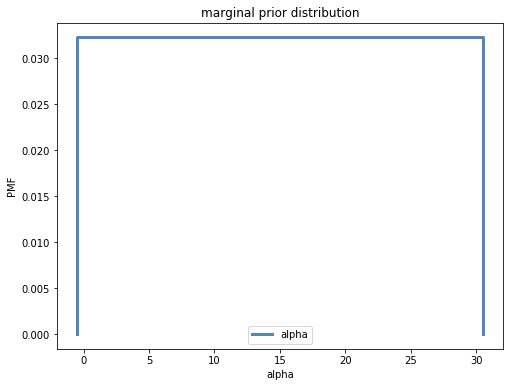

In [24]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf( suite2.Marginal(0, label='alpha') )
thinkplot.Config(xlabel='alpha',
                ylabel='PMF',
                title='marginal prior distribution')

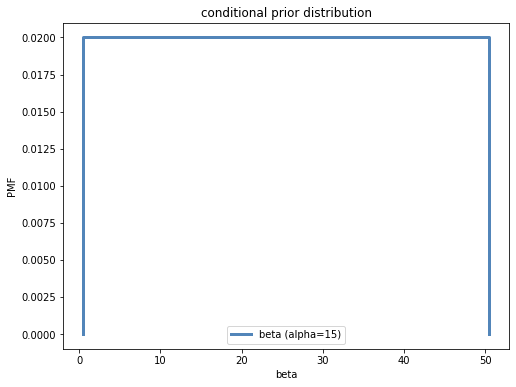

In [25]:
a = 15
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf( suite2.Conditional(1, 0, a, label=f'beta (alpha={a})') )
thinkplot.Config(xlabel='beta',
                ylabel='PMF',
                title='conditional prior distribution')

Update with the observed values of `x`:

In [26]:
suite2.UpdateSet([15, 16, 18, 21])

2.545383385451073e-06

Check posteriors (and compare to previous case):

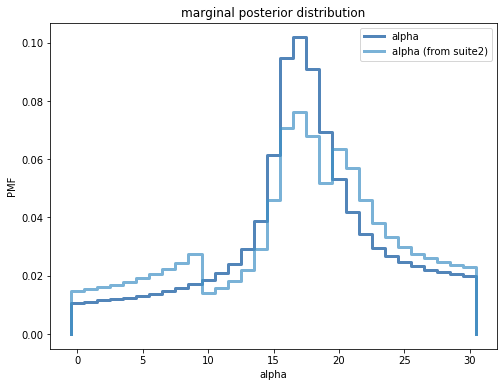

In [28]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmfs( [suite.Marginal(0, label='alpha'), suite2.Marginal(0, label='alpha (from suite2)')] )
thinkplot.Config(xlabel='alpha',
                ylabel='PMF',
                title='marginal posterior distribution')

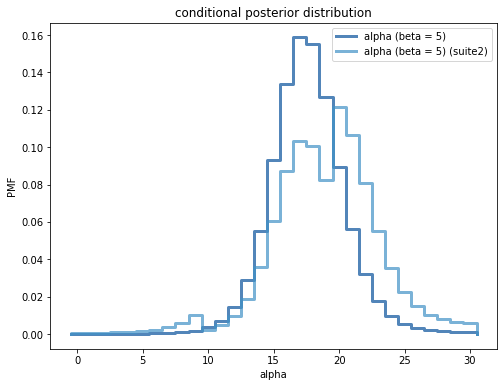

In [31]:
beta = 5
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmfs( [suite.Conditional(0, 1, beta, label=f'alpha (beta = {beta})'), suite2.Conditional(0, 1, beta, label=f'alpha (beta = {beta}) (suite2)')] )
thinkplot.Config(xlabel='alpha',
                ylabel='PMF',
                title='conditional posterior distribution')

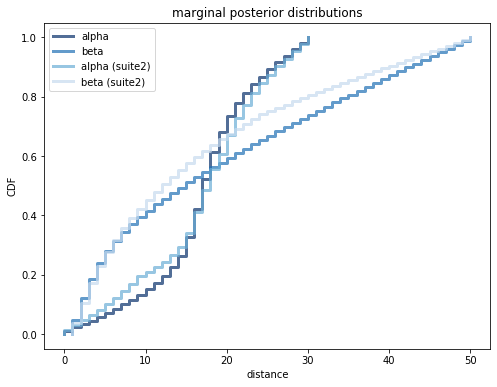

In [33]:
thinkplot.Clf()
thinkplot.PrePlot(num=4)
thinkplot.Pdfs( [suite.Marginal(0, label='alpha').MakeCdf(), suite.Marginal(1, label='beta').MakeCdf(), suite2.Marginal(0, label='alpha (suite2)').MakeCdf(), suite2.Marginal(1, label='beta (suite2)').MakeCdf()] )
thinkplot.Config(xlabel='distance',
                ylabel='CDF',
                title='marginal posterior distributions')

In [36]:
percentages = [25, 50, 75]

## create an empty dictionary (pair) --> prob
d2 = dict((pair, 0) for pair in suite2.Values())

for p in percentages:
    
    ## get the pairs in the given percentage
    interval = suite2.MaxLikeInterval(p)
    
    for pair in interval:
        d2[pair] += 1
    

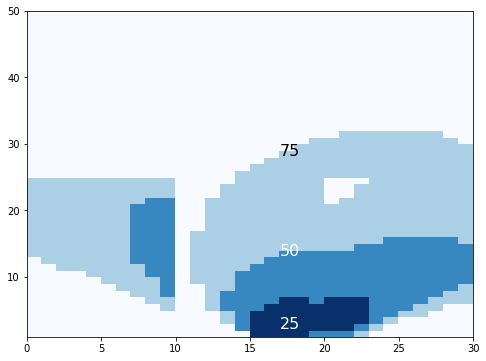

In [37]:
thinkplot.Clf()
thinkplot.Contour(d2, pcolor=True, contour=False)

thinkplot.Text(17, 4, '25', color='white')
thinkplot.Text(17, 15, '50', color='white')
thinkplot.Text(17, 30, '75')

Interesting! The heavily discontinuous shape of P(alpha, beta) is due to the weird shape of P(x|alpha, beta). With the new form of the likelihood we are way less confident of where the shooter is :)